In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load cleaned and grouped dataset
df = pd.read_csv("../data/processed_features.csv")

# Encode the new grouped pitch type column
le_group = LabelEncoder()
df['pitch_type_group_encoded'] = le_group.fit_transform(df['pitch_type_group'])

# Save the label encoder for future use 
joblib.dump(le_group, "../results/group_label_encoder.pkl")

# Define features (drop both original pitch_type and the group text column)
X = df.drop(['pitch_type', 'pitch_type_group', 'pitch_type_group_encoded'], axis=1)
y = df['pitch_type_group_encoded']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
joblib.dump(scaler, "../results/scaler.pkl")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "../results/pitch_predictor_model.pkl")

# Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_group.classes_, zero_division=0))



Accuracy: 0.53

Classification Report:
              precision    recall  f1-score   support

    Breaking       0.37      0.31      0.34     43435
    Fastball       0.62      0.71      0.66     84882
    Offspeed       0.23      0.14      0.17     14898
       Other       0.58      0.43      0.49       357

    accuracy                           0.53    143572
   macro avg       0.45      0.40      0.42    143572
weighted avg       0.50      0.53      0.51    143572



In [4]:
pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   --- ------------------------------------ 14.7/150.0 MB 92.4 MB/s eta 0:00:02
   ---------- ---------------------------- 40.1/150.0 MB 106.3 MB/s eta 0:00:02
   -------------- ------------------------- 52.7/150.0 MB 90.7 MB/s eta 0:00:02
   ---------------- ----------------------- 61.3/150.0 MB 76.6 MB/s eta 0:00:02
   ---------------------- ----------------- 84.9/150.0 MB 84.7 MB/s eta 0:00:01
   --------------------------- ----------- 107.0/150.0 MB 88.7 MB/s eta 0:00:01
   --------------------------------- ----- 130.5/150.0 MB 92.7 MB/s eta 0:00:01
   --------------------------------------  149.9/150.0 MB 94.9 MB/s eta 0:00:01
   --------------------------------------- 150.0/150.0 MB 84.8 MB/s eta 0:00:00


In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=le_group.classes_, zero_division=0))

# Optional: Save model
import joblib
joblib.dump(xgb_model, "../results/xgb_pitch_predictor_model.pkl")


c:\Users\susov\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:49:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.61

XGBoost Classification Report:
              precision    recall  f1-score   support

    Breaking       0.53      0.16      0.25     43435
    Fastball       0.61      0.93      0.74     84882
    Offspeed       0.51      0.04      0.07     14898
       Other       0.66      0.70      0.68       357

    accuracy                           0.61    143572
   macro avg       0.58      0.46      0.43    143572
weighted avg       0.58      0.61      0.52    143572



['../results/xgb_pitch_predictor_model.pkl']

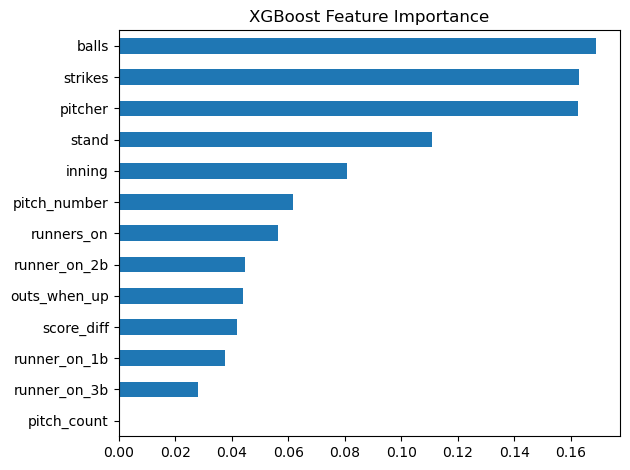

In [7]:
import matplotlib.pyplot as plt

importance = xgb_model.feature_importances_
feat_imp = pd.Series(importance, index=X.columns).sort_values()
feat_imp.plot(kind='barh', title="XGBoost Feature Importance")
plt.tight_layout()
plt.show()


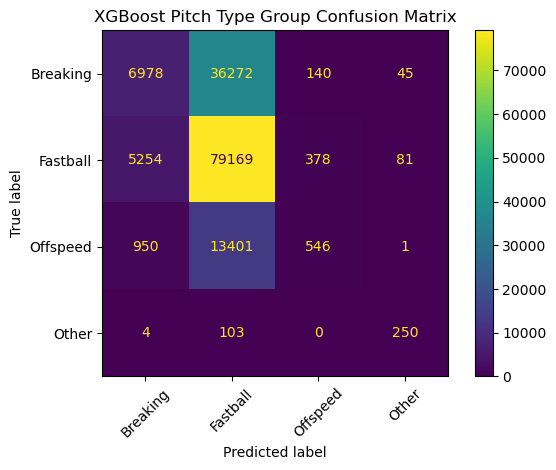

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    xgb_model, X_test, y_test, display_labels=le_group.classes_, xticks_rotation=45
)
plt.title("XGBoost Pitch Type Group Confusion Matrix")
plt.tight_layout()
plt.show()
